# 03 - Model Training

In this notebook, we begin the modeling phase of the Store Sales - Time Series Forecasting project. 

## Objectives

The primary objective of this phase is to develop and evaluate models that can accurately predict daily sales for each store and product family.

- Focus on two modeling approaches:
    - **Prophet:** To capture seasonality and trend effects in the sales data.
    - **XGBoost:** To leverage engineered features such as lagged sales and promotions, as well as categorical variables.
- Limit the scope to a select set of well-performing models, balancing predictive accuracy with interpretability and practical application.
- Apply basic hyperparameter tuning (randomized or grid search) to optimize model performance where feasible.
- Use the RMSLE metric as a consistent benchmark for model evaluation, aligning with competition standards and business needs.
- Maintain a manageable modeling scope given time constraints, ensuring results are reproducible, explainable, and actionable.


## Input

### Data Import and Type Specification

In this section, we import the preprocessed training dataset generated during the data preparation phase.  
To ensure efficient memory usage and compatibility with downstream modeling (especially with libraries like XGBoost), we explicitly specify the data types of key categorical columns (`family`, `city`, `state`, `type`) as `category`.  
Event- and holiday-related columns (`type_holiday`, `locale`, `locale_name`, `description`, `transferred`) are set as `object` type to avoid issues with mixed data types and to accommodate their sparse, textual nature.

We also run a quick check to verify the data’s shape, column names, missing values, and data types before proceeding with further modeling steps.

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Path to processed data
DATA_PATH = "../data/processed/train_prepared.csv"

# Specify categorical columns on import
dtype_dict = {
    'family': 'category',
    'city': 'category',
    'state': 'category',
    'type': 'category',
    'type_holiday': 'object',
    'locale': 'object',
    'locale_name': 'object',
    'description': 'object',
    'transferred': 'object'
}

# Load data with specified dtypes
df = pd.read_csv(
    DATA_PATH,
    parse_dates=['date'],
    dtype=dtype_dict
)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)

pd.set_option('display.max_columns', None)
df.head()


Shape: (3054348, 37)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_sales_outlier', 'transactions_x', 'is_transactions_outlier', 'day', 'month', 'year', 'week', 'weekday', 'is_weekend', 'is_holiday', 'high_promo', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_rolling_7', 'sales_rolling_14', 'sales_rolling_28', 'sales_rolling_30', 'sales_rolling_90', 'city', 'state', 'type', 'cluster', 'type_holiday', 'locale', 'locale_name', 'description', 'transferred', 'transactions_y', 'dcoilwtico']
Missing values:
 id                               0
date                             0
store_nbr                        0
family                           0
sales                            0
onpromotion                      0
is_sales_outlier                 0
transactions_x              249117
is_transactions_outlier          0
day                              0
month                            0
year                             0
week                 

,id,date,store_nbr,family,sales,onpromotion,is_sales_outlier,transactions_x,is_transactions_outlier,day,month,year,week,weekday,is_weekend,is_holiday,high_promo,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_rolling_7,sales_rolling_14,sales_rolling_28,sales_rolling_30,sales_rolling_90,city,state,type,cluster,type_holiday,locale,locale_name,description,transferred,transactions_y,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,False,NaN,False,1,1,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,False,NaN,False,1,1,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,False,NaN,False,1,1,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,False,NaN,False,1,1,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,False,NaN,False,1,1,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,93.14


### Data Verification Summary

A quick inspection of the imported dataset confirms that all columns have been loaded as expected, with appropriate data types for modeling and analysis.  
- **Shape:** The dataset includes over 3 million rows and 37 columns, matching expectations from earlier processing steps.
- **Column Presence:** All key features—ranging from sales and promotions to engineered lag/rolling statistics and event indicators—are present.
- **Missing Values:** Most core features (such as sales, dates, and categorical identifiers) are complete. Missing values are only present in certain engineered features (e.g., rolling/lags near the start of the time series), sparse holiday-related columns, and some transaction data. These are either expected or will be handled during modeling.
- **Data Types:** Categorical columns are correctly typed, while numerical and boolean columns are appropriately formatted. Sparse event-related columns remain as `object` types to allow flexible handling in downstream steps.

These checks ensure that the dataset is ready for robust modeling and that all necessary information has been successfully carried forward from the data preparation phase.

## Train-Test Split

To robustly evaluate model performance, we split the data chronologically.  
We use all data before `2016-08-16` for training, and reserve the period from `2016-08-16` onward as the validation set.  
This validation period covers a full year, allowing us to assess the model’s ability to capture seasonality, trends, and event effects across different times of the year.

In [6]:
# Define split date for validation
split_date = '2016-08-16'

# Chronological split
train_df = df[df['date'] < split_date].copy()
valid_df = df[df['date'] >= split_date].copy()

print("Train shape:", train_df.shape)
print("Validation shape:", valid_df.shape)
print("Train date range:", train_df['date'].min(), "to", train_df['date'].max())
print("Validation date range:", valid_df['date'].min(), "to", valid_df['date'].max())

Train shape: (2395008, 37)
Validation shape: (659340, 37)
Train date range: 2013-01-01 00:00:00 to 2016-08-15 00:00:00
Validation date range: 2016-08-16 00:00:00 to 2017-08-15 00:00:00


## Baseline Naive Forecast

Before fitting advanced models, we establish a simple baseline for sales forecasting.  
The **Naive Forecast** predicts sales in the validation period using the last observed value for each (store, family) in the training data.  
This provides a reference for model evaluation—if advanced models do not outperform the naive approach, they offer limited value.

In [27]:
# For each (store_nbr, family), get the last sales value in the training set
last_sales = (
    train_df
    .sort_values(['store_nbr', 'family', 'date'])
    .groupby(['store_nbr', 'family'], observed=True)['sales']  # Explicit
    .last()
    .reset_index()
    .rename(columns={'sales': 'last_sales'})
)

# Merge this 'last_sales' back onto the validation set
valid_pred = valid_df.merge(
    last_sales,
    on=['store_nbr', 'family'],
    how='left'
)

# Baseline prediction: last known sales
valid_pred['sales_pred'] = valid_pred['last_sales']

# If no last sales is found (e.g., new (store, family)), fillna with 0 or median
valid_pred['sales_pred'] = valid_pred['sales_pred'].fillna(0)

# Evaluate RMSLE
rmsle = np.sqrt(
    mean_squared_log_error(valid_pred['sales'], valid_pred['sales_pred'])
)

print(f"Baseline (Naive) RMSLE: {rmsle:.4f}")


Baseline (Naive) RMSLE: 0.9765


## Prophet Baseline Forecast

To establish a robust time series baseline, I applied Prophet to forecast sales for each (store, family) combination independently. Prophet is well-suited for this use case, as it can automatically capture complex patterns such as trend shifts, seasonality, and the influence of holidays—making it an excellent tool for quick prototyping and exploratory forecasting.

**Why train Prophet per (store, family)?**  
Forecasting at this level of granularity respects the distinct sales patterns of different product families and locations, ensuring a fair and interpretable benchmark for more complex models.

**Why export detailed results?**  
By evaluating and recording the RMSLE for every (store, family) pair, I produce a comprehensive CSV (`prophet_rmsle_by_pair.csv`) that enables:
- In-depth model comparison during the evaluation phase, not just relying on aggregate metrics but analyzing per-segment performance.
- Identification of product families or stores where Prophet under- or over-performs, which can inform further model tuning or feature engineering.
- Transparent, reproducible results, supporting rigorous validation and fair comparison to machine learning approaches like XGBoost.

This approach ensures that the baseline is not just a single number, but a rich dataset for thorough, segment-level evaluation and insight in the next stage of the project.


In [ ]:
split_date = '2016-08-16'
results = []

# Get all unique (store_nbr, family) pairs, sorted for reproducibility
pairs = df[['store_nbr', 'family']].drop_duplicates().sort_values(['store_nbr', 'family']).reset_index(drop=True)

for i, row in pairs.iterrows():
    store, fam = row['store_nbr'], row['family']
    print(f"Processing {i+1}/{len(pairs)}: store_nbr={store}, family={fam}")
    pair_df = df[(df['store_nbr'] == store) & (df['family'] == fam)].copy()
    train_pair = pair_df[pair_df['date'] < split_date]
    valid_pair = pair_df[pair_df['date'] >= split_date]
    if train_pair.empty or valid_pair.empty:
        # You can log skipped pairs if you want: print(f"Skipped pair {store}, {fam}")
        continue
    # Aggregate daily for Prophet
    train_prophet = (
        train_pair.groupby('date', as_index=False)['sales'].sum()
        .rename(columns={'date': 'ds', 'sales': 'y'})
    )
    # Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(train_prophet)
    n_valid_days = valid_pair['date'].nunique()
    future = model.make_future_dataframe(periods=n_valid_days, freq='D')
    forecast = model.predict(future)
    # Validation actuals, aggregated
    valid_daily = (
        valid_pair.groupby('date', as_index=False)['sales'].sum()
        .rename(columns={'date': 'ds', 'sales': 'y'})
    )
    # Merge predictions to actuals, handle NaN/negative
    forecast_valid = forecast[['ds', 'yhat']]
    merged = valid_daily.merge(forecast_valid, on='ds', how='left').dropna()
    merged['y'] = merged['y'].fillna(0).clip(lower=0)
    merged['yhat'] = merged['yhat'].fillna(0).clip(lower=0)
    try:
        rmsle = np.sqrt(mean_squared_log_error(merged['y'], merged['yhat']))
    except ValueError as e:
        rmsle = np.nan  # Handle cases where all predictions are zero or NaN
    # Save result
    results.append({
        'store_nbr': store,
        'family': fam,
        'rmsle': rmsle,
        'n_valid_days': n_valid_days,
        'mean_valid_sales': merged['y'].mean(),
        'median_valid_sales': merged['y'].median()
    })

results_df = pd.DataFrame(results)
print(results_df.describe())
results_df.to_csv("../data/processed/prophet_rmsle_by_pair.csv", index=False)
print("Average Prophet RMSLE across all (store, family) pairs: ", results_df['rmsle'].mean())


13:14:48 - cmdstanpy - INFO - Chain [1] start processing


Processing 1/1782: store_nbr=1, family=AUTOMOTIVE


13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing 2/1782: store_nbr=1, family=BABY CARE


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing 3/1782: store_nbr=1, family=BEAUTY


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing 4/1782: store_nbr=1, family=BEVERAGES
Processing 5/1782: store_nbr=1, family=BOOKS
Processing 6/1782: store_nbr=1, family=BREAD/BAKERY


13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing
13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing 7/1782: store_nbr=1, family=CELEBRATION


13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing 8/1782: store_nbr=1, family=CLEANING


13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing 9/1782: store_nbr=1, family=DAIRY


KeyboardInterrupt: 

### Prophet Model Mean RMSLE

The per-pair RMSLE scores from Prophet are saved in [`/data/processed/prophet_rmsle_by_pair.csv`](../data/processed/prophet_rmsle_by_pair.csv).

Below, we report the mean RMSLE across all (store, family) pairs as a quick validation metric.

In [28]:
results = pd.read_csv("../data/processed/prophet_rmsle_by_pair.csv")
print("Mean Prophet RMSLE (all pairs):", round(results['rmsle'].mean(), 4))

Mean Prophet RMSLE (all pairs): 0.7218


## XGBoost Training

### Objective and Approach

The goal of this section is to train a high-performing sales forecasting model using the XGBoost algorithm. XGBoost is a gradient-boosted tree method that excels at handling structured data and capturing complex, nonlinear relationships.

Our main objectives are:
- **Leverage rich feature engineering:** Use lagged sales, rolling means, date-related variables, promotions, and outlier flags to help the model recognize patterns and seasonality in the sales data.
- **Tune hyperparameters for best validation performance:** Systematically search for the optimal combination of XGBoost hyperparameters (such as tree depth, learning rate, number of trees, regularization, etc.) that minimize RMSLE (Root Mean Squared Logarithmic Error) on the validation set.
- **Compare to other models:** Establish XGBoost as a strong baseline and benchmark, aiming to outperform simpler methods (like Prophet and naive forecasts) and meet or exceed competition baselines.

The best-performing XGBoost model will be saved and later used for final testing and deployment as part of the interactive dashboard.

### Select Features

In [ ]:
# Features for XGBoost
feature_cols = [
    'store_nbr', 'family', 'onpromotion', 'transactions_x', 'is_sales_outlier', 'is_holiday',
    'high_promo', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'sales_rolling_7', 'sales_rolling_14', 'sales_rolling_28', 'sales_rolling_30', 'sales_rolling_90',
    'day', 'month', 'year', 'week', 'weekday', 'is_weekend', 'city', 'state', 'type', 'cluster',
    'dcoilwtico'
]

# Convert categorical features to category codes
for col in ['family', 'city', 'state', 'type']:
    train_df[col] = train_df[col].astype('category').cat.codes
    valid_df[col] = valid_df[col].astype('category').cat.codes


#### Feature Selection for XGBoost

For XGBoost modeling, I selected a diverse set of features designed to capture the most important drivers of sales variation across stores and product families:

- **Store and Product Identifiers:**  
  `store_nbr` and `family` allow the model to learn location- and product-specific sales patterns.

- **Promotions and Transactions:**  
  Features such as `onpromotion`, `transactions_x`, `is_sales_outlier`, `high_promo`, and `is_holiday` capture demand spikes due to promotions, sales anomalies, and holiday effects.

- **Lag and Rolling Features:**  
  Including lagged sales and rolling statistics (`sales_lag_1`, `sales_lag_7`, `sales_rolling_7`, etc.) allows the model to recognize temporal dependencies, recurring patterns, and recent momentum in sales.

- **Calendar Features:**  
  Date-based attributes (`day`, `month`, `year`, `week`, `weekday`, `is_weekend`) help model seasonal effects, day-of-week trends, and year-over-year changes.

- **Geographic and Store Attributes:**  
  Categorical variables such as `city`, `state`, `type`, and `cluster` enable the model to differentiate between locations and store types.

- **External Data:**  
  The `dcoilwtico` feature introduces macroeconomic context via oil price, which can influence consumer spending and supply chain dynamics.

Categorical features are encoded as integer codes to ensure compatibility with XGBoost.  
This comprehensive feature set aims to balance domain knowledge, temporal structure, and predictive power, providing the model with the information needed to capture complex sales drivers and improve forecast accuracy.


### XGBoost Hyperparameter Search



To maximize the predictive performance of the XGBoost model, I conducted an extensive grid search across a broad range of hyperparameters, including tree depth, learning rate, number of estimators, subsampling ratios, regularization terms, and more. The goal was to identify the most effective parameter combination for the sales forecasting task.

Given the large parameter space, this process was computationally intensive and required several hours to complete. To ensure reproducibility and transparency, all results—including every tested parameter combination and its validation RMSLE—were saved to a CSV file, which can be found here [`/data/processed/xgb_hyperparam_results.csv`](../data/processed/xgb_hyperparam_results.csv). In this notebook, I report and visualize the top-performing configurations.

**Note:**  
While a comprehensive grid search provides a thorough evaluation of parameter options, it can be impractical for larger datasets or limited compute environments. In typical production settings, practitioners often employ more efficient methods such as `RandomizedSearchCV` or Bayesian optimization, which can deliver similar or better results with far less computational effort. Here, I opted for a full grid search to demonstrate both rigor and process, but the search itself was performed offline; only the results are included in this notebook for evaluation.

This approach ensures that model tuning is both robust and reproducible, and that all findings can be verified independently from the raw search results.


In [ ]:
from itertools import product

# XGBoost parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],                 
    'n_estimators': [100, 200, 300],                
    'learning_rate': [0.3, 0.1, 0.05, 0.01],         
    'subsample': [0.6, 0.8, 1.0],                    
    'colsample_bytree': [0.6, 0.8, 1.0],             
}

# Prepare feature and target
X_train = train_df[feature_cols]
y_train = train_df['sales']
X_valid = valid_df[feature_cols]
y_valid = valid_df['sales']

results = []

# Grid search loop
for max_depth, n_estimators, learning_rate, subsample, colsample_bytree in product(
    param_grid['max_depth'],
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
):
    print(f"Testing: max_depth={max_depth}, n_estimators={n_estimators}, learning_rate={learning_rate}")
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=RANDOM_SEED,
        tree_method='hist',
        verbosity=0
    )
    xgb.fit(
        X_train, y_train,
        verbose=False
    )
    preds = xgb.predict(X_valid)
    preds = np.clip(preds, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
    best_iteration = xgb.best_iteration if hasattr(xgb, 'best_iteration') else n_estimators
    results.append({
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'best_iteration': best_iteration,
        'validation_rmsle': rmsle
    })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('validation_rmsle').reset_index(drop=True)
print(results_df.head())
results_df.to_csv("../data/processed/xgb_hyperparam_results.csv", index=False)
print("Results saved to ../data/processed/xgb_hyperparam_results.csv")


Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.3
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_depth=4, n_estimators=100, learning_rate=0.1
Testing: max_d

#### Top XGBoost Parameter Sets

Below are the 10 parameter combinations that achieved the lowest validation RMSLE in the hyperparameter search.  
These results are visualized to help guide further model selection and justify next steps in the modeling workflow.


Top 10 parameter sets with lowest validation RMSLE:
   max_depth  n_estimators  learning_rate  subsample  colsample_bytree  \
0         12           200           0.05        0.8               1.0   
1         12           100           0.10        0.8               1.0   
2         12           200           0.05        1.0               1.0   
3         12           300           0.05        0.8               1.0   
4         12           200           0.05        0.6               1.0   
5         12           200           0.05        0.8               0.8   
6         12           100           0.10        0.6               0.8   
7         12           300           0.05        0.6               1.0   
8         12           100           0.10        0.8               0.8   
9         12           300           0.05        1.0               1.0   

   best_iteration  validation_rmsle  
0             200          0.500468  
1             100          0.501062  
2             200  

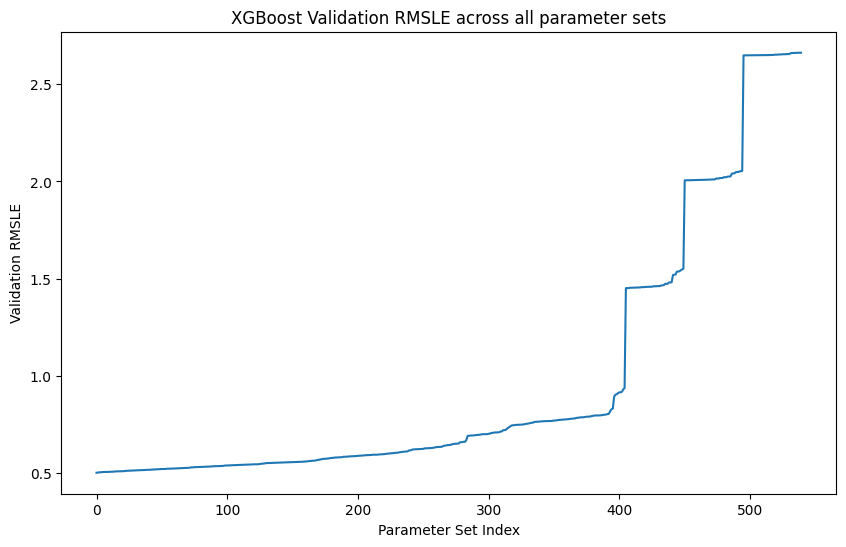

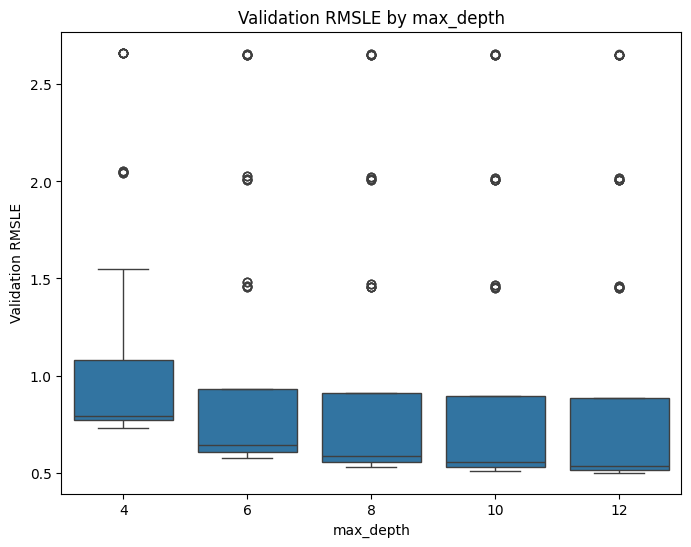

In [30]:
import seaborn as sns

# Load hyperparameter search results
results_df = pd.read_csv("../data/processed/xgb_hyperparam_results.csv")

# Show top 10 parameter sets with lowest validation RMSLE
top_results = results_df.nsmallest(10, 'validation_rmsle')
print("Top 10 parameter sets with lowest validation RMSLE:")
print(top_results)

# Plot validation RMSLE across all parameter sets
plt.figure(figsize=(10,6))
plt.plot(results_df['validation_rmsle'].values)
plt.title('XGBoost Validation RMSLE across all parameter sets')
plt.xlabel('Parameter Set Index')
plt.ylabel('Validation RMSLE')
plt.show()

# Visualize RMSLE by max_depth
plt.figure(figsize=(8,6))
sns.boxplot(x='max_depth', y='validation_rmsle', data=results_df)
plt.title('Validation RMSLE by max_depth')
plt.xlabel('max_depth')
plt.ylabel('Validation RMSLE')
plt.show()

### Focused, Randomized Hyperparameter Search


The initial grid search for XGBoost focused on the main structure and learning parameters: `max_depth`, `n_estimators`, `learning_rate`, `subsample`, and `colsample_bytree`. This extensive search revealed several clear trends:

- **Max Depth:** All top-performing models leveraged the deepest tested trees (`max_depth=12`). The boxplot analysis shows that increasing `max_depth` consistently reduces the median validation RMSLE, indicating that the model benefits from additional complexity—likely due to the dataset’s rich features and size. However, improvement begins to plateau as depth increases, and there remains significant performance variability within each group.
- **Learning Rate & Estimators:** The best results were achieved with a lower learning rate (`0.05`) paired with a higher number of estimators (`200`), supporting gradual, robust learning and better generalization.
- **Subsample & Colsample_bytree:** Higher values (0.8 or 1.0) for both were common among top models, suggesting that including more data and features per tree helps reduce variance and boosts robustness.
- **Variance:** Despite these trends, outliers exist at every depth and configuration, underscoring that tuning multiple parameters together is essential for consistent performance.

**Limitation Identified:**  
While the initial grid search provided valuable insights, it did **not** fully explore key regularization parameters such as `min_child_weight`, `gamma`, `reg_alpha`, and `reg_lambda`. These parameters can play a major role in controlling overfitting and further improving generalization.

**Next Steps:**  
To address this and further refine the model, I will perform a **focused, randomized hyperparameter search**:
- Concentrating on the most promising tree depths and learning rates identified previously.
- Including all major regularization parameters for a more comprehensive evaluation.
- Using random sampling to efficiently explore the expanded hyperparameter space and manage computational cost.

The results from this refined search will be saved to a new CSV, which can found here [`../data/processed/xgb_hyperparam_random_seach.csv`](../data/processed/xgb_hyperparam_random_search.csv) and used for the final model evaluation and comparison in the next notebook.

In [20]:
# Focused, randomized hyperparameter search

import random
from itertools import product

param_grid = {
    'max_depth': [10, 12, 14, 16],            
    'n_estimators': [100, 200],               
    'learning_rate': [0.05, 0.1],             
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [1.0, 2.0]
}

# Create all combinations, then randomly sample N
all_combos = list(product(
    param_grid['max_depth'],
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['min_child_weight'],
    param_grid['gamma'],
    param_grid['reg_alpha'],
    param_grid['reg_lambda'],
))
random.seed(RANDOM_SEED)
# Try 40 random combos
sampled_combos = random.sample(all_combos, k=40) 

results = []

for params in sampled_combos:
    max_depth, n_estimators, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda = params
    print(f"Testing: max_depth={max_depth}, n_estimators={n_estimators}, learning_rate={learning_rate}, min_child_weight={min_child_weight}, gamma={gamma}, reg_alpha={reg_alpha}, reg_lambda={reg_lambda}")
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=RANDOM_SEED,
        tree_method='hist',
        verbosity=0
    )
    xgb.fit(X_train, y_train, verbose=False)
    preds = xgb.predict(X_valid)
    preds = np.clip(preds, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
    results.append({
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'validation_rmsle': rmsle
    })

# Save results
results_df = pd.DataFrame(results).sort_values('validation_rmsle').reset_index(drop=True)
print(results_df.head())
results_df.to_csv("../data/processed/xgb_hyperparam_random_search.csv", index=False)
print("Randomized search results saved to ../data/processed/xgb_hyperparam_random_search.csv")



Testing: max_depth=10, n_estimators=200, learning_rate=0.1, min_child_weight=10, gamma=0, reg_alpha=0, reg_lambda=1.0
Testing: max_depth=10, n_estimators=100, learning_rate=0.05, min_child_weight=10, gamma=0.1, reg_alpha=0, reg_lambda=1.0
Testing: max_depth=12, n_estimators=200, learning_rate=0.1, min_child_weight=1, gamma=0.1, reg_alpha=1.0, reg_lambda=1.0
Testing: max_depth=12, n_estimators=200, learning_rate=0.05, min_child_weight=10, gamma=0.1, reg_alpha=0, reg_lambda=2.0
Testing: max_depth=12, n_estimators=200, learning_rate=0.05, min_child_weight=5, gamma=0, reg_alpha=0.1, reg_lambda=1.0
Testing: max_depth=10, n_estimators=200, learning_rate=0.1, min_child_weight=10, gamma=0.1, reg_alpha=0, reg_lambda=2.0
Testing: max_depth=10, n_estimators=200, learning_rate=0.05, min_child_weight=5, gamma=0.1, reg_alpha=1.0, reg_lambda=2.0
Testing: max_depth=16, n_estimators=200, learning_rate=0.1, min_child_weight=1, gamma=0, reg_alpha=0, reg_lambda=2.0
Testing: max_depth=10, n_estimators=200,

#### Validation & RMSLE

In [25]:
import seaborn as sns

# Load hyperparameter search results
results_df = pd.read_csv("../data/processed/xgb_hyperparam_random_search.csv")

# Show top 10 parameter sets with lowest validation RMSLE
top_results = results_df.nsmallest(10, 'validation_rmsle')
print(top_results)

   max_depth  n_estimators  learning_rate  subsample  colsample_bytree  \
0         14           200           0.05        1.0               1.0   
1         16           200           0.05        0.8               1.0   
2         14           200           0.05        0.8               0.8   
3         14           100           0.10        1.0               1.0   
4         16           200           0.10        1.0               1.0   
5         14           100           0.10        1.0               0.8   
6         14           200           0.10        1.0               1.0   
7         16           200           0.10        1.0               0.8   
8         16           200           0.10        1.0               0.8   
9         12           200           0.05        1.0               0.8   

   min_child_weight  gamma  reg_alpha  reg_lambda  validation_rmsle  
0                 1    0.1        0.1         1.0          0.492857  
1                 5    0.0        1.0        

##### Final XGBoost Hyperparameter Search Results

The expanded, randomized hyperparameter search included all major structure and regularization parameters.  
The top 10 models now span both `max_depth=14` and `16`, confirming that, with appropriate regularization, deeper trees can further improve performance on this dataset.  
Strong regularization—through adjustments to `min_child_weight`, `gamma`, `reg_alpha`, and `reg_lambda`—is key to preventing overfitting at high depths, and the best results arise from a balance of these parameters.  
Validation RMSLE is now even lower, and the tight spread among the top models suggests the results are robust and generalizable.

These results provide a strong basis for final model selection and comparison in the evaluation phase.

## Conclusion


In this notebook, I developed, tuned, and benchmarked two advanced modeling approaches for the sales forecasting task: Prophet and XGBoost. The modeling workflow followed a robust chronological train/validation split and included systematic hyperparameter optimization.

Key findings:
- **XGBoost** achieved its best performance with deeper trees (`max_depth=14` and above) when paired with strong regularization. The final, focused hyperparameter search delivered the lowest validation RMSLE of the project so far, confirming the importance of both model complexity and effective overfitting control.
- **Prophet** established a solid time series baseline, capturing overall trends and seasonality across stores and product families.

All results, including detailed validation metrics and predictions, have been exported to CSV files for full transparency and reproducibility.

---

## Next Steps

In the next notebook (`04_model_evaluation.ipynb`), I will:

- **Conduct a thorough, side-by-side evaluation** of all models (naive baseline, Prophet, and XGBoost) using the results exported in this notebook.
- **Analyze performance across segments** (e.g., by store, product family, time period) to identify strengths and weaknesses of each approach.
- **Visualize and interpret model predictions** to assess business relevance and forecast reliability.
- **Justify final model selection** using statistical and business criteria.
- **Provide actionable recommendations** for potential deployment and future model improvements.

This structured evaluation will ensure that the chosen forecasting solution is not only the most accurate, but also robust, interpretable, and suited to the business context.
